## Implementing the strategy using OOP

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import pyfolio as pf
import warnings
warnings.filterwarnings('ignore')

C:\Users\balaji\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


In [2]:
from datetime import date
from nsepy import get_history

In [3]:
# Fetching data
# Create start and end dates for the past 252 days
end1 = pd.datetime.now().date()
start1 = end1-pd.Timedelta(days=252)
end1

datetime.date(2020, 10, 24)

In [4]:
start1

datetime.date(2020, 2, 15)

In [99]:
class backtesting_crossover:
    def __init__(self, ticker, start_date, end_date, ma_short, ma_middle, ma_long):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.ma_short = ma_short
        self.ma_middle = ma_middle
        self.ma_long = ma_long
        ## calling necessary instance methods(defined below)
        self.fetch_data()
        self.indicators()
        self.signals()
        self.positions()
        self.returns()
        self.analysis()
        self.signal_performance()
        
    
    def fetch_data(self):
        #self.df = get_history(symbol=self.ticker,start=start_date,end=end_date,index=True)
         self.df = yf.download(self.ticker, self.start_date, self.end_date)
        
    def indicators(self):
        self.df['ma_short'] = self.df['Close'].rolling(window = self.ma_short, center = False).mean()
        self.df['ma_middle'] = self.df['Close'].rolling(window = self.ma_middle, center = False).mean()
        self.df['ma_long'] = self.df['Close'].rolling(window = self.ma_long, center = False).mean()
        self.df['Close_prev'] = self.df['Close'].shift()
        self.df['ma_short_prev'] = self.df['ma_short'].shift()
        self.df['ma_middle_prev'] = self.df['ma_middle'].shift()
        self.df['ma_long_prev'] = self.df['ma_long'].shift()
        self.df.dropna(inplace=True)
    
    def signals(self):
        ## LONG_signal
        self.df['signal'] = np.where((self.df['Close'] > self.df['ma_short']) & (self.df['Close_prev'] < self.df['ma_short_prev'])
                                    & (self.df['Close'] > self.df['ma_middle']) & (self.df['Close_prev'] < self.df['ma_middle_prev'])
                                    & (self.df['Close'] > self.df['ma_long']) & (self.df['Close_prev'] < self.df['ma_long_prev']),1,0)
        ## sell_signal
        self.df['signal'] = np.where((self.df['Close'] < self.df['ma_short']) & (self.df['Close_prev'] > self.df['ma_short_prev'])
                                    | (self.df['Close'] < self.df['ma_middle']) & (self.df['Close_prev'] > self.df['ma_middle_prev'])
                                    | (self.df['Close'] < self.df['ma_long']) & (self.df['Close_prev'] > self.df['ma_long_prev']),0,self.df['signal'])
        
        ## SHORT_signal
        self.df['signal'] = np.where((self.df['Close'] < self.df['ma_short']) & (self.df['Close_prev'] > self.df['ma_short_prev'])
                                    & (self.df['Close'] < self.df['ma_middle']) & (self.df['Close_prev'] > self.df['ma_middle_prev'])
                                    & (self.df['Close'] < self.df['ma_long']) & (self.df['Close_prev'] > self.df['ma_long_prev']),-1,self.df['signal'])
        ## buy_signal
        self.df['signal'] = np.where((self.df['Close'] > self.df['ma_short']) & (self.df['Close_prev'] < self.df['ma_short_prev'])
                                    | (self.df['Close'] > self.df['ma_middle']) & (self.df['Close_prev'] < self.df['ma_middle_prev'])
                                    | (self.df['Close'] > self.df['ma_long']) & (self.df['Close_prev'] < self.df['ma_long_prev']),0,self.df['signal'])
        
    def positions(self):
        self.df['position'] = self.df['signal'].replace(to_replace=0, method='ffill')
        
    def returns(self):
        self.df['bnh_returns'] = np.log(self.df['Close'] / self.df['Close'].shift(1))
        self.df['strategy_returns'] = self.df['bnh_returns'] * self.df['position'].shift(1)
        print('Total Return: ', self.df['strategy_returns'].sum())
    
    def signal_performance(self):
        
        self.df['daily_return'] = np.log(self.df['Close']/self.df['Close'].shift(1))
        self.df['strategy_return'] = self.df['daily_return']*self.df['position'].shift(1)
        self.df['Market_Return']=self.df['daily_return'].expanding().sum()
        self.df['wins'] = np.where(self.df['strategy_returns'] > 0,1,0)
        self.df['Losses'] = np.where(self.df['strategy_returns'] < 0,1,0)
        
        
        d_perform = {}
        d_perform['Buy and Hold Return'] = self.df['daily_return'].sum()
        d_perform['strategy_return'] = self.df['strategy_returns'].sum()
        d_perform['diff Str_Ret and BH_Ret']=self.df['strategy_returns'].sum() - self.df['daily_return'].sum()
        d_perform['MaxDrawdown'] = (1.0-self.df['strategy_returns']/self.df['Market_Return'].cummax()).max()
        d_perform['TotalWins'] = self.df['wins'].sum()
        d_perform['TotalLosses'] = self.df['Losses'].sum()
        d_perform['TotalTrades'] = d_perform['TotalWins'] + d_perform['TotalLosses']
        d_perform['HitRatio'] = round(d_perform['TotalWins']/d_perform['TotalTrades'],2)
        d_perform['sharpe_ratio'] = self.df['strategy_returns'].mean()/self.df['strategy_returns'].std()*(252**0.5)
        self.daywise_performance = pd.Series(d_perform)

        
    
    def analysis(self):
        # Plot to check if the strategy is working as planned:
        self.df[['Close','ma_short','ma_middle','ma_long','position']].plot(figsize=(15,6),secondary_y='position',grid=True)
        plt.title('checking if positions are generated properly')
        plt.show()
        
        # Plot to check how the strategy performs relative to buy & hold
        self.df[['bnh_returns','strategy_returns']].cumsum().plot(figsize=(15,6),secondary_y='position',grid=True,
                                                                 title=f'{self.ticker} | ma1={self.ma_short} | ma2={self.ma_middle} | ma3={self.ma_long}')
        plt.title("Buy & hold vs Crossover strategy cumulative returns")
        plt.show()
        
        # general analytics
        pf.create_simple_tear_sheet(self.df['strategy_returns'])

In [100]:
# Create start and end dates for the past 252 days
end1 = pd.datetime.now().date()
start1 = end1-pd.Timedelta(days=252)

In [101]:
start1

datetime.date(2020, 2, 15)

In [102]:
end1

datetime.date(2020, 10, 24)

[*********************100%***********************]  1 of 1 completed
Total Return:  -0.09527242685495024


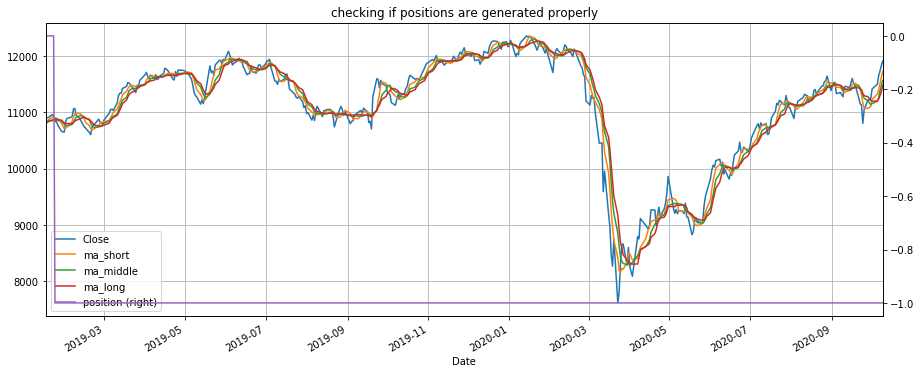

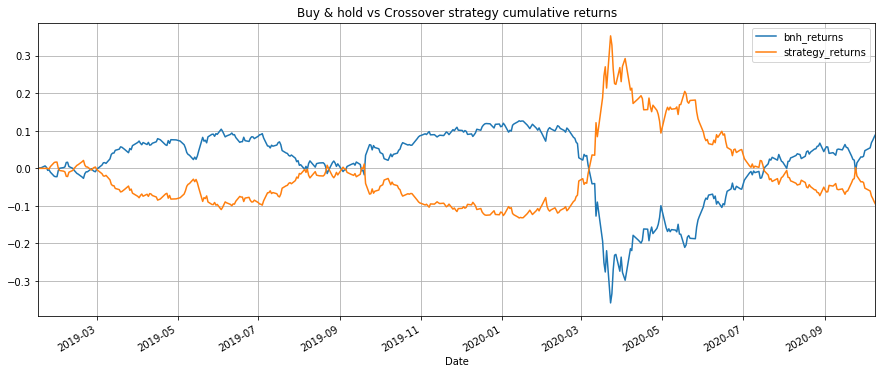

Start date,2019-01-16
End date,2020-10-09
Total months,20
,Backtest
Annual return,-8.5%
Cumulative returns,-14.0%
Annual volatility,25.9%
Sharpe ratio,-0.22
Calmar ratio,-0.23
Stability,0.01
Max drawdown,-37.5%


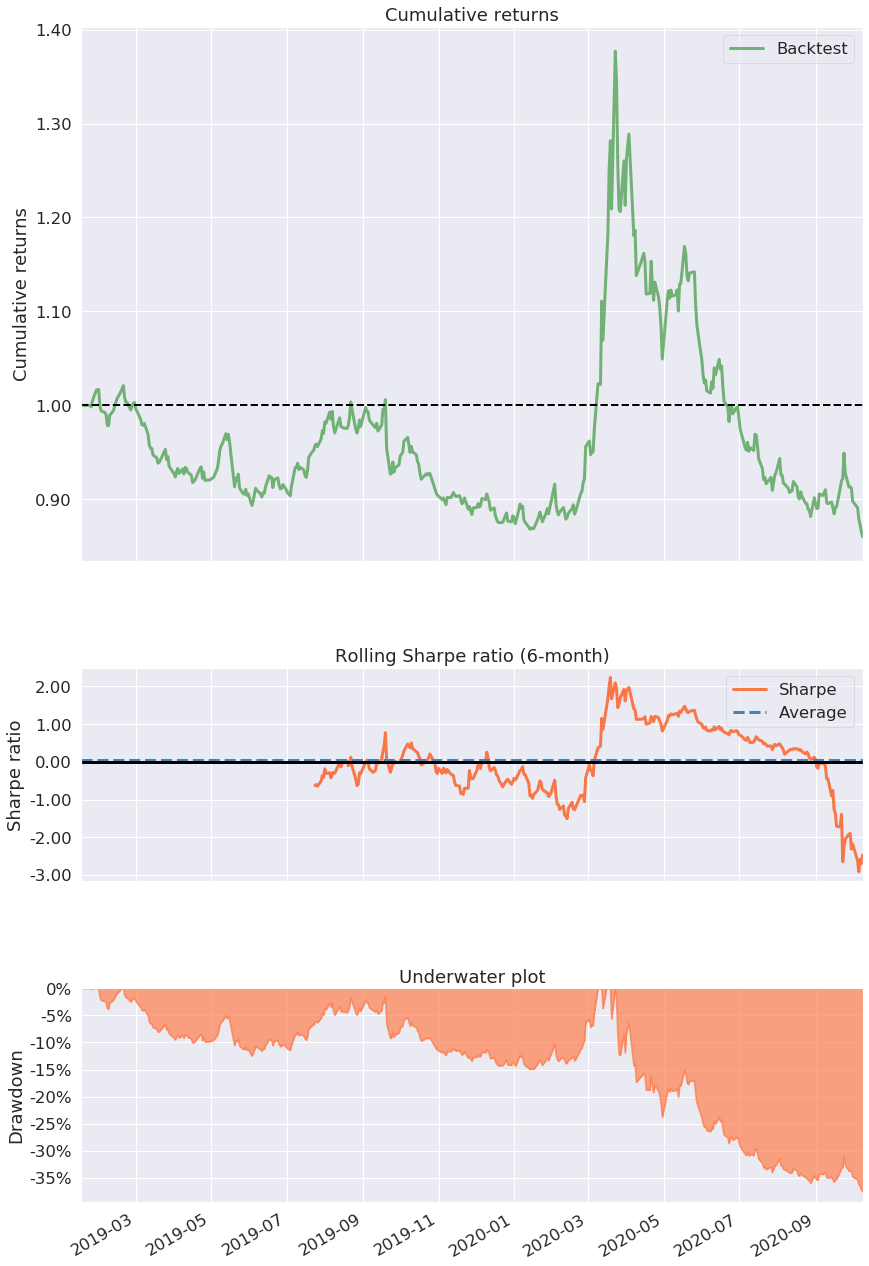

In [103]:
nifty = backtesting_crossover('^NSEI',date(2019,1,1),date(2020,10,10),5,8,10)

In [104]:
nifty.signal_performance()

In [105]:
nifty.daywise_performance

Buy and Hold Return          0.089859
strategy_return             -0.095272
diff Str_Ret and BH_Ret     -0.185131
MaxDrawdown                  3.546960
TotalWins                  197.000000
TotalLosses                222.000000
TotalTrades                419.000000
HitRatio                     0.470000
sharpe_ratio                -0.218667
dtype: float64